# Sparse Bottleneck Networks for Exploratory Analysis and Visualization of Neural Patch-seq Data

In [1]:
# Import packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import seaborn as sns
import sparseRRR
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import importlib

import bottleneck_networks

import time
import pickle
import warnings

dtype = tf.float32

# Loading data

In [2]:
scala = pickle.load(open('data/scala_2020/scala2020.pickle', 'rb'))
gouwens = pickle.load(open('data/gouwens_2020/gouwens2020.pickle', 'rb'))

In [56]:
scala['ephys_features']

Index(['AP amp', 'AP amp adapt', 'AP amp CV', 'AP thresh', 'AP width', 'AHP',
       'AI', 'ISI CV', 'R_input', 'Max AP num', 'Tau', 'Rebound', 'V_rest',
       'Rheobase', 'Sag', 'UDR'],
      dtype='object')

# Keras initialisations

In [3]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [5]:
def r2_score(y_truth, y_pred):
    residual = tf.add(y_truth, -y_pred, name='residual')
    return 1-tf.reduce_sum(tf.square(residual)) / tf.reduce_sum(tf.square(y_truth))

In [6]:
class ElasticNet(tf.keras.regularizers.Regularizer): 
    def __init__(self, l1=1e-8, l2=1.0): 
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x): 
        return self.l2*tf.math.reduce_sum(tf.math.square(x)) + \
                             self.l1*tf.reduce_sum(tf.norm(x, ord = 2, axis = 1))

    def get_config(self): 
        return {'l1': float(self.l1), 'l2': float(self.l2)}

# Combined Figure

First some functions

In [7]:
def latent_space_ephys(model, X, Y, Y_column_index, features, alpha = 1, axis = None):
    '''
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    Y: 2D numpy array, normalized ephys data
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    '''
    # Create mappings from the model to get latent activations from genes and ephys predictions from genes and
    # latent activations
    encoder = Model(model.input, model.get_layer('bottleneck').output)
    latent = encoder.predict(X)
    ephys_prediction = model.predict(X)

    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    ax.tricontourf(latent[:, 0], latent[:, 1], ephys_prediction[:, Y_column_index], cmap='inferno')
    ax.set_xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
    ax.set_ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [8]:
def latent_space_genes(model, latent, X, X_column_index, geneNames, alpha = 1, axis = None):
    '''
    Parameters
    ----------
    model: keras decoder network (from latent space to selected genes)
    latent: bottleneck activations
    X: 2D numpy array, normalized transcriptomic data (should be a selected genes i.e. reduced size matrix)
    X_column_index: column index in X, correspoding to certain gene
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    '''
    gene_prediction=model.predict(latent)
    
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    ax.tricontourf(latent[:, 0], latent[:, 1], gene_prediction[:, X_column_index], cmap='inferno')
    ax.set_xlim([np.min(latent[:, 0]), np.max(latent[:, 0])])
    ax.set_ylim([np.min(latent[:, 1]), np.max(latent[:, 1])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[X_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [9]:
def create_axes(fig):
    # return axes to construct big figure
    
    if fig is None:
        fig = plt.figure(figsize=(9, 9))
    else: fig = fig
    
    ax_scheme = plt.axes([0, 0.68, .42, .36])               #(left, bottom, width, height) defines rectangle
    ax_training_curves = plt.axes([0.52, 0.77, .45, 0.22])
    
    width = 0.1 # width of every small heatmap plot
    height = 0.1 # height of every small heatmap plot
    
    s_ax_latent=plt.axes([.33,0.37,0.33,0.33])
    s_ax_genes_1=plt.axes([0,0.59,width,height])
    s_ax_genes_2=plt.axes([0.11,0.59,width,height])
    s_ax_genes_3=plt.axes([0.22,0.59,width,height])
    
    s_ax_genes_4=plt.axes([0,0.48,width,height])
    s_ax_genes_5=plt.axes([0.11,0.48,width,height])
    s_ax_genes_6=plt.axes([0.22,0.48,width,height])
    
    s_ax_genes_7=plt.axes([0,0.37,width,height])
    s_ax_genes_8=plt.axes([0.11,0.37,width,height])
    s_ax_genes_9=plt.axes([0.22,0.37,width,height])
    
    s_ax_ephys_1=plt.axes([0.66,0.59, width,height])
    s_ax_ephys_2=plt.axes([0.77,0.59, width,height])
    s_ax_ephys_3=plt.axes([0.88,0.59, width,height])
    
    s_ax_ephys_4=plt.axes([0.66,0.48, width,height])
    s_ax_ephys_5=plt.axes([0.77,0.48, width,height])
    s_ax_ephys_6=plt.axes([0.88,0.48, width,height])
    
    s_ax_ephys_7=plt.axes([0.66,0.37, width,height])
    s_ax_ephys_8=plt.axes([0.77,0.37, width,height])
    s_ax_ephys_9=plt.axes([0.88,0.37, width,height])
    
    g_ax_latent=plt.axes([.33,0,0.33,0.33])
    
    g_ax_genes_1=plt.axes([0,0.22,width,height])
    g_ax_genes_2=plt.axes([0.11,0.22,width,height])
    g_ax_genes_3=plt.axes([0.22,0.22,width,height])
    
    g_ax_genes_4=plt.axes([0,0.11,width,height])
    g_ax_genes_5=plt.axes([0.11,0.11,width,height])
    g_ax_genes_6=plt.axes([0.22,0.11,width,height])
    
    g_ax_genes_7=plt.axes([0,0,width,height])
    g_ax_genes_8=plt.axes([0.11,0,width,height])
    g_ax_genes_9=plt.axes([0.22,0,width,height])
    
    g_ax_ephys_1=plt.axes([0.66,0.22, width,height])
    g_ax_ephys_2=plt.axes([0.77,0.22, width,height])
    g_ax_ephys_3=plt.axes([0.88,0.22, width,height])
    
    g_ax_ephys_4=plt.axes([0.66,0.11, width,height])
    g_ax_ephys_5=plt.axes([0.77,0.11, width,height])
    g_ax_ephys_6=plt.axes([0.88,0.11, width,height])
    
    g_ax_ephys_7=plt.axes([0.66, 0, width,height])
    g_ax_ephys_8=plt.axes([0.77, 0, width,height])
    g_ax_ephys_9=plt.axes([0.88, 0, width,height])
    return [ax_scheme, ax_training_curves, \
            s_ax_latent, s_ax_genes_1, s_ax_genes_2, s_ax_genes_3, s_ax_genes_4, s_ax_genes_5, s_ax_genes_6, \
            s_ax_genes_7, s_ax_genes_8, s_ax_genes_9, s_ax_ephys_1, s_ax_ephys_2, s_ax_ephys_3, s_ax_ephys_4, \
            s_ax_ephys_5, s_ax_ephys_6, s_ax_ephys_7, s_ax_ephys_8, s_ax_ephys_9, \
            g_ax_latent, g_ax_genes_1, g_ax_genes_2, g_ax_genes_3, g_ax_genes_4, g_ax_genes_5, g_ax_genes_6, \
            g_ax_genes_7, g_ax_genes_8, g_ax_genes_9, g_ax_ephys_1, g_ax_ephys_2, g_ax_ephys_3, g_ax_ephys_4, \
            g_ax_ephys_5, g_ax_ephys_6, g_ax_ephys_7, g_ax_ephys_8, g_ax_ephys_9]

Then we load some results

In [10]:
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])
cvfold_id=1111
weights_after_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format('gouwens_2020', cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
g_weights_after_unfreezing = np.array(weights_after_unfreezing)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
weights_after_unfreezing = []
for j, l1 in enumerate(l1_params):
    saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_full_dataset_{}_{}_{}.h5'.\
                             format('scala_2020', cvfold_id, j, 0), \
                             custom_objects={'r2_score': r2_score, 'ElasticNet': ElasticNet})
    weights_after_unfreezing.append(saved_model.get_weights()[0])
s_weights_after_unfreezing = np.array(weights_after_unfreezing)

In [12]:
lasso_id=2
cvfold_id=1111
g_saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format('gouwens_2020', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
g_encoder = Model(g_saved_model.input, g_saved_model.get_layer('bottleneck').output)
g_ind_genes = np.argsort(np.linalg.norm(g_weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
g_latent = g_encoder.predict(gouwens['X'][:, g_ind_genes])                 # bottleneck representation

g_saved_model_AE = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_AE_{}_{}_{}.h5'.\
                        format('gouwens_2020', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

In [13]:
lasso_id=2
cvfold_id=1111
s_saved_model = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_{}_{}_{}.h5'.\
                        format('scala_2020', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

# Retrieve activations and ephys prediction
s_encoder = Model(s_saved_model.input, s_saved_model.get_layer('bottleneck').output)
s_ind_genes = np.argsort(np.linalg.norm(s_weights_after_unfreezing, ord=2, axis=2), axis = 1)[lasso_id, :][-25:]
s_latent = s_encoder.predict(scala['X'][:, s_ind_genes])                 # bottleneck representation

s_saved_model_AE = load_model('KerasSavedModels/{}/FreezeUnfreeze_after_unfreezing_ap_full_dataset_AE_{}_{}_{}.h5'.\
                        format('scala_2020', cvfold_id, lasso_id, 0), \
                        custom_objects={'ElasticNet': ElasticNet, 'r2_score': r2_score})

In [14]:
lambdas = np.arange(.5,3,.1)
alphas = np.array([1])

with open('KerasSavedModels/scala_2020/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)
    
with open('KerasSavedModels/scala_2020/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
            nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)
    
with open('KerasSavedModels/scala_2020/Bottleneck_r2_straight_regr_lasso.pickle', 'rb') as f:
    r2_straight_regr, r2_straight_regr_tr, \
    r2_straight_regr_ap, r2_straight_regr_ap_tr, \
    r2_straight_regr_hist, r2_straight_regr_hist_tr = pickle.load(f)

with open('KerasSavedModels/scala_2020/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'rb') as f:
    r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
    r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
    r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr = pickle.load(f)

with open('KerasSavedModels/scala_2020/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
    r2_after_unfreezing, r2_after_unfreezing_tr, \
    r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
    r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

And now we can show it all together

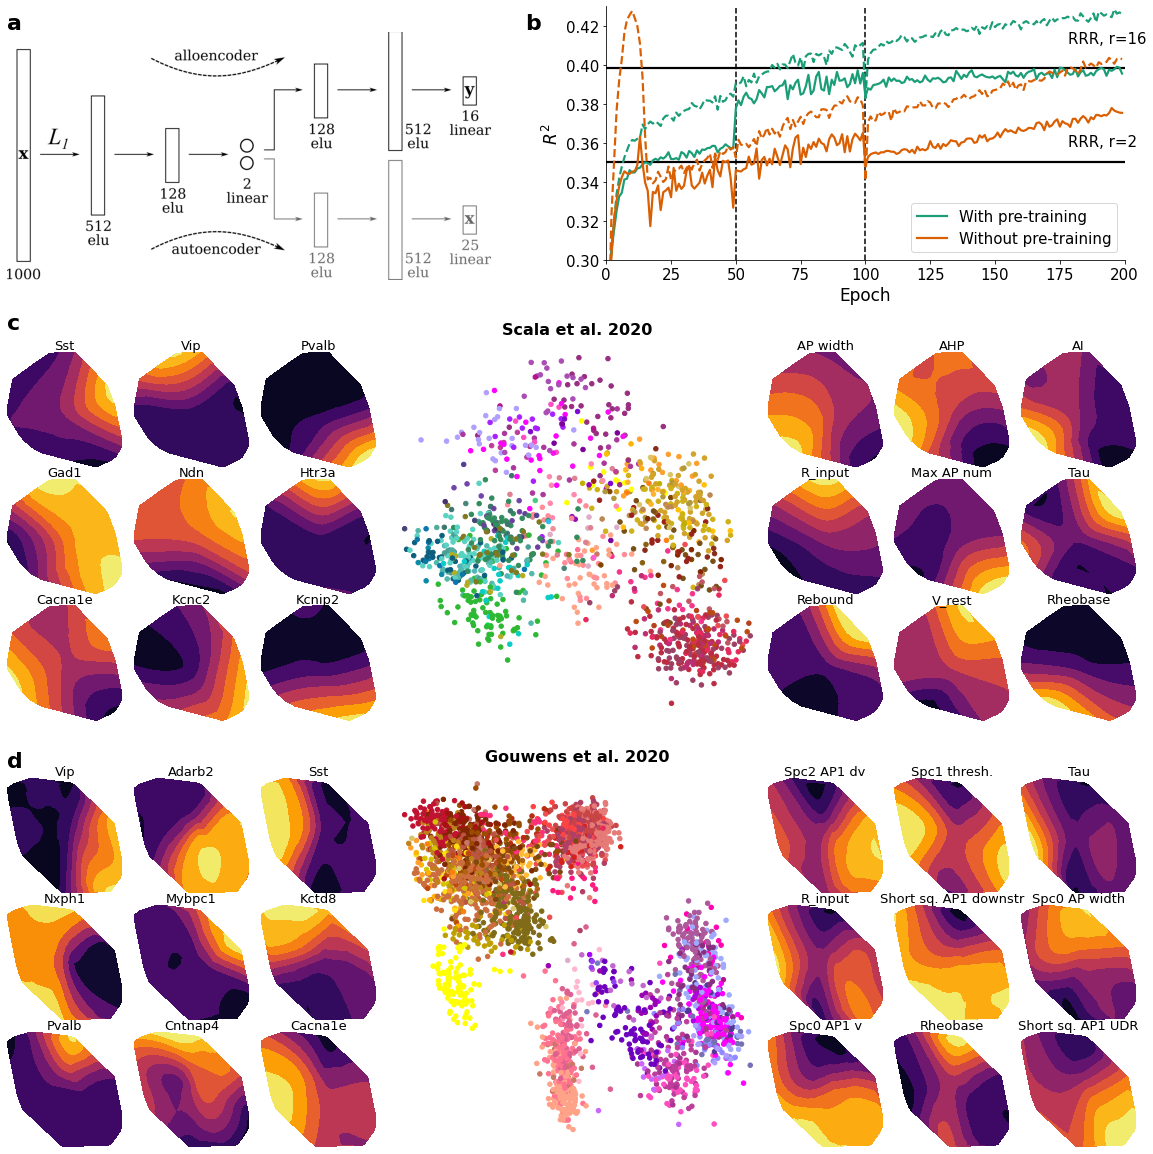

In [54]:
fig=plt.figure(figsize=(16,16))
ax_list = create_axes(fig)


########################
# sBNN schema

ax_list[0].imshow(mpimg.imread('./figures/schematic-autoallo.png'))
ax_list[0].set_xticks([])
ax_list[0].set_yticks([])
ax_list[0].set_xticklabels('')
ax_list[0].set_yticklabels('')


########################
# Lasso Scala training curves

epochs_used=200
linewidth = 2.2
ax_list[1].plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0))[2,0,:], \
         '--', c = '#1b9e77', linewidth=linewidth)
ax_list[1].plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis=(0))[2,0,:], \
         c = '#1b9e77', linewidth=linewidth, label='With pre-training')
ax_list[1].plot(range(epochs_used), np.mean(r2_straight_regr_hist_tr, axis=(0))[0,0,:], \
         '--', c = '#d95f02', linewidth=linewidth)
ax_list[1].plot(range(epochs_used), np.mean(r2_straight_regr_hist, axis=(0))[0,0,:], \
         c = '#d95f02', linewidth=linewidth, label='Without pre-training')
ax_list[1].hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=4)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax_list[1].hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=2)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax_list[1].set_ylim([0.3,0.43])
ax_list[1].set_xlim([0,200])
ax_list[1].set_xticks(np.arange(0, 225, 25))
ax_list[1].annotate('RRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=4)][0]+0.013), fontsize=15)
ax_list[1].annotate('RRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=2)][0]+0.008), fontsize=15)
ax_list[1].set_xlabel('Epoch', fontsize = 17)
ax_list[1].set_ylabel(r'$R^2$', fontsize = 17)
ax_list[1].tick_params(axis='both', which='major', labelsize=15)
ax_list[1].tick_params(axis='both', which='minor', labelsize=15)
ax_list[1].legend(loc='lower right', fontsize=15) #, bbox_to_anchor=(0.75, 0.25, 0.3, 0.3), fontsize=14)
ax_list[1].vlines(x=50, ymin=ax_list[1].get_ylim()[0], ymax=ax_list[1].get_ylim()[1], linestyles='dashed')
ax_list[1].vlines(x=100, ymin=ax_list[1].get_ylim()[0], ymax=ax_list[1].get_ylim()[1], linestyles='dashed')


########################
# Scala dataset

ax_list[2].scatter(s_latent[:, 0], s_latent[:, 1],
            c = [scala['colors'][ctype] for ctype in scala['map']], s=20)
ax_list[2].set_xticks([])
ax_list[2].set_yticks([])
ax_list[2].set_title('Scala et al. 2020', fontsize=16, fontweight='bold')
s_gene_feature_indices_for_visualization=[-1,-2,-3,-4,-5,15,1,8,12]
for i, ax in enumerate(ax_list[3:12]):
    latent_space_genes(s_saved_model_AE, s_latent, scala['X'][:, s_ind_genes], 
        s_gene_feature_indices_for_visualization[i], scala['gene_names'][s_ind_genes], axis=ax)
s_ephys_feature_indices_for_visualization=[4,5,6,8,9,10,11,12,13]
for i, ax in enumerate(ax_list[12:21]):
    latent_space_ephys(s_saved_model, scala['X'][:, s_ind_genes], scala['Y'], \
        s_ephys_feature_indices_for_visualization[i], scala['ephys_features'], axis=ax)


########################
# Gouwens dataset

ax_list[21].scatter(g_latent[:, 0], g_latent[:, 1],
            c = [gouwens['colors'][ctype] for ctype in gouwens['map']], s=20)
ax_list[21].set_xticks([])
ax_list[21].set_yticks([])
ax_list[21].set_title('Gouwens et al. 2020', fontsize=16, fontweight='bold')
for i, ax in enumerate(ax_list[22:31]):
    latent_space_genes(g_saved_model_AE, g_latent, gouwens['X'][:, g_ind_genes], 
        -(i+1), gouwens['gene_names'][g_ind_genes], axis=ax)
g_ephys_feature_indices_for_visualization=[ 7, 27, 46, 45, 41, 29,  0, 50, 42]
for i, ax in enumerate(ax_list[31:40]):
    latent_space_ephys(g_saved_model, gouwens['X'][:, g_ind_genes], gouwens['Y'], \
        g_ephys_feature_indices_for_visualization[i], gouwens['ephys_features'], axis=ax)

# I check the consistency of shorter and original names in the next code block
gouwens_shorter_ephys_names_to_show=['Spc2 AP1 dv', 'Spc1 thresh.', 'Tau', 'R_input', \
                                                          'Short sq. AP1 downstr', 'Spc0 AP width', \
                                                          'Spc0 AP1 v', 'Rheobase', 'Short sq. AP1 UDR']
for i, ax in enumerate(ax_list[31:40]):
    ax.set_title(gouwens_shorter_ephys_names_to_show[i], fontsize=13, y=0.97)

sns.despine(ax=ax_list[0],left=True,bottom=True)
for ax in ax_list[2:]:
    sns.despine(ax=ax,left=True, bottom=True)
sns.despine(ax=ax_list[1])
    
fig.text(.0, .97, 'a', fontsize=22, fontweight='bold')
fig.text(.45, .97, 'b', fontsize=22, fontweight='bold')
fig.text(.0, .71, 'c', fontsize=22, fontweight='bold')
fig.text(.0, .33, 'd', fontsize=22, fontweight='bold')


plt.savefig('figures/combined_figure.png', bbox_inches = 'tight',
     pad_inches = 0)
plt.savefig('figures/combined_figure.pdf', bbox_inches = 'tight',
    pad_inches = 0)

In [16]:
# Checking consistency of ephys long and shorter names for Gouwens
print('old names: ', gouwens['ephys_features'][g_ephys_feature_indices_for_visualization])
print('new names: ', gouwens_shorter_ephys_names_to_show)

old names:  ['spc2 first AP dv' 'spc1 spk. thr. v' 'tau' 'input resistance'
 'short sq. AP1 downstroke' 'spc0 spk. width' 'spc0 first AP v'
 'rheobase i' 'short sq. AP1 up-down ratio']
new names:  ['Spc2 AP1 dv', 'Spc1 thresh.', 'Tau', 'R_input', 'Short sq. AP1 downstr', 'Spc0 AP width', 'Spc0 AP1 v', 'Rheobase', 'Short sq. AP1 UDR']


# Linear variant

In [20]:
def latent_space_ephys_sRRR(X, vx, vy, Y_column_index, features, alpha = 1, axis = None):

    '''
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure object, latent space with ephys activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    ax.tricontourf((X@vx)[:, 1], (X@vx)[:, 0], (X@vx@vy.T)[:, Y_column_index], \
                  cmap='inferno')
    ax.set_xlim([np.min((X@vx)[:, 1]), np.max((X@vx)[:, 1])])
    ax.set_ylim([np.min((X@vx)[:, 0]), np.max((X@vx)[:, 0])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [21]:
def latent_space_genes_sRRR(X, vx, index, geneNames, alpha = 0.5, axis = None):
    ''' 
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    index: index in the 25 genes selected for the gene that you'd like to show
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    alpha: transparancy for contours (default = 0.5)
    ax: axis to plot one (default: None)
    
    Returns
    -------
    axis: figure objects; latent space with gene activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))

    ax.tricontourf((X@vx)[:,1], (X@vx)[:,0], X@vx@np.linalg.pinv(vx)[:, np.sum(vx, axis = 1)!=0][:, index], \
                  cmap='inferno')
    ax.set_xlim([np.min((X@vx)[:, 1]), np.max((X@vx)[:, 1])])
    ax.set_ylim([np.min((X@vx)[:, 0]), np.max((X@vx)[:, 0])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[np.sum(vx, axis = 1)!=0][index], fontsize=13, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [39]:
def create_axes_linear(fig):
    # return axes to construct big figure
    
    if fig is None:
        fig = plt.figure(figsize=(9, 6))
    else: fig = fig
    
    width = 0.1 # width of every small heatmap plot
    height = 0.12 # height of every small heatmap plot
    
    s_ax_latent=plt.axes([.33,0.55,0.33,0.47])
    s_ax_genes_1=plt.axes([0,0.85,width,height])
    s_ax_genes_2=plt.axes([0.11,0.85,width,height])
    s_ax_genes_3=plt.axes([0.22,0.85,width,height])
    
    s_ax_genes_4=plt.axes([0,0.69,width,height])
    s_ax_genes_5=plt.axes([0.11,0.69,width,height])
    s_ax_genes_6=plt.axes([0.22,0.69,width,height])
    
    s_ax_genes_7=plt.axes([0,0.53,width,height])
    s_ax_genes_8=plt.axes([0.11,0.53,width,height])
    s_ax_genes_9=plt.axes([0.22,0.53,width,height])
    
    s_ax_ephys_1=plt.axes([0.66,0.85, width,height])
    s_ax_ephys_2=plt.axes([0.77,0.85, width,height])
    s_ax_ephys_3=plt.axes([0.88,0.85, width,height])
    
    s_ax_ephys_4=plt.axes([0.66,0.69, width,height])
    s_ax_ephys_5=plt.axes([0.77,0.69, width,height])
    s_ax_ephys_6=plt.axes([0.88,0.69, width,height])
    
    s_ax_ephys_7=plt.axes([0.66,0.53, width,height])
    s_ax_ephys_8=plt.axes([0.77,0.53, width,height])
    s_ax_ephys_9=plt.axes([0.88,0.53, width,height])
    
    g_ax_latent=plt.axes([.33,0,0.33,0.47])
    
    g_ax_genes_1=plt.axes([0,0.32,width,height])
    g_ax_genes_2=plt.axes([0.11,0.32,width,height])
    g_ax_genes_3=plt.axes([0.22,0.32,width,height])
    
    g_ax_genes_4=plt.axes([0,0.16,width,height])
    g_ax_genes_5=plt.axes([0.11,0.16,width,height])
    g_ax_genes_6=plt.axes([0.22,0.16,width,height])
    
    g_ax_genes_7=plt.axes([0,0,width,height])
    g_ax_genes_8=plt.axes([0.11,0,width,height])
    g_ax_genes_9=plt.axes([0.22,0,width,height])
    
    g_ax_ephys_1=plt.axes([0.66,0.32, width,height])
    g_ax_ephys_2=plt.axes([0.77,0.32, width,height])
    g_ax_ephys_3=plt.axes([0.88,0.32, width,height])
    
    g_ax_ephys_4=plt.axes([0.66,0.16, width,height])
    g_ax_ephys_5=plt.axes([0.77,0.16, width,height])
    g_ax_ephys_6=plt.axes([0.88,0.16, width,height])
    
    g_ax_ephys_7=plt.axes([0.66, 0, width,height])
    g_ax_ephys_8=plt.axes([0.77, 0, width,height])
    g_ax_ephys_9=plt.axes([0.88, 0, width,height])
    return [s_ax_latent, s_ax_genes_1, s_ax_genes_2, s_ax_genes_3, s_ax_genes_4, s_ax_genes_5, s_ax_genes_6, \
            s_ax_genes_7, s_ax_genes_8, s_ax_genes_9, s_ax_ephys_1, s_ax_ephys_2, s_ax_ephys_3, s_ax_ephys_4, \
            s_ax_ephys_5, s_ax_ephys_6, s_ax_ephys_7, s_ax_ephys_8, s_ax_ephys_9, \
            g_ax_latent, g_ax_genes_1, g_ax_genes_2, g_ax_genes_3, g_ax_genes_4, g_ax_genes_5, g_ax_genes_6, \
            g_ax_genes_7, g_ax_genes_8, g_ax_genes_9, g_ax_ephys_1, g_ax_ephys_2, g_ax_ephys_3, g_ax_ephys_4, \
            g_ax_ephys_5, g_ax_ephys_6, g_ax_ephys_7, g_ax_ephys_8, g_ax_ephys_9]

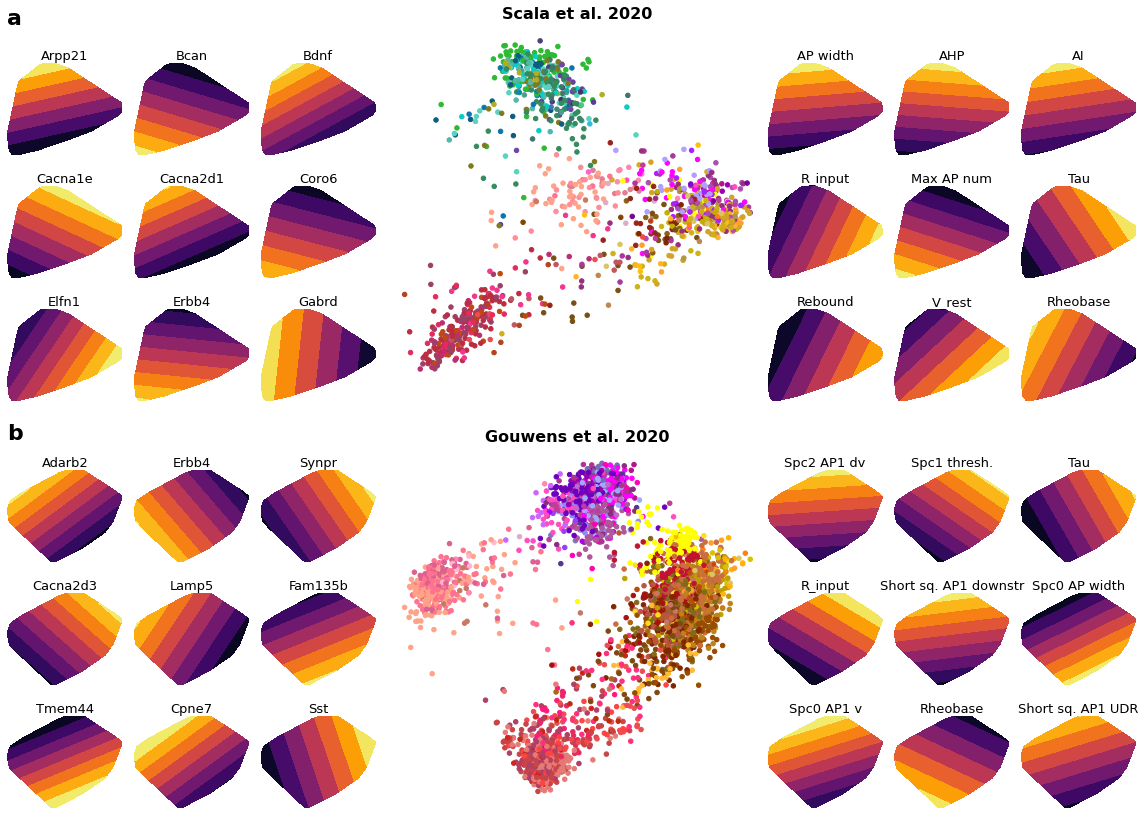

In [45]:
fig = plt.figure(figsize=(16, 16*(2/3)))
ax_list=create_axes_linear(fig)

########################
# Scala dataset

lambdas_scala = np.arange(.1,2,.1)

with open('KerasSavedModels/scala_2020/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2_scala = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r_scala = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16_scala = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r_scala = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

seed=42
np.random.seed(seed)
n = scala['X'].shape[0]

vx_rank2, vy_rank2 = sparseRRR.elastic_rrr(scala['X'].astype('float64'), scala['Y'].astype('float64'), \
                            lambdau=lambdas_scala[np.isclose(n_rank2_scala, 25, atol=3)][0], \
                                           alpha=1, rank=2, sparsity='row-wise')

ax_list[0].scatter((scala['X']@vx_rank2)[:, 1], (scala['X']@vx_rank2)[:, 0],
            c = [scala['colors'][ctype] for ctype in scala['map']], s=20)
ax_list[0].set_xticks([])
ax_list[0].set_yticks([])
ax_list[0].set_title('Scala et al. 2020', fontsize=16, fontweight='bold')
for i, ax in enumerate(ax_list[1:10]):
    latent_space_genes_sRRR(scala['X'], vx_rank2, 
        i, scala['gene_names'], axis=ax)
s_ephys_feature_indices_for_visualization=[4,5,6,8,9,10,11,12,13]
for i, ax in enumerate(ax_list[10:19]):
    latent_space_ephys_sRRR(scala['X'], vx_rank2, vy_rank2, \
        s_ephys_feature_indices_for_visualization[i], scala['ephys_features'], axis=ax)
sns.despine(left=True, bottom=True)

########################
# Gouwens dataset

lambdas_gouwens = np.arange(.5,3,.1)
with open('KerasSavedModels/gouwens_2020/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2_gouwens = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r_gouwens = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16_gouwens = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r_gouwens = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

seed=42
np.random.seed(seed)
n = gouwens['X'].shape[0]
vx_rank2, vy_rank2 = sparseRRR.elastic_rrr(gouwens['X'].astype('float64'), gouwens['Y'].astype('float64'), \
                            lambdau=lambdas_gouwens[np.isclose(n_rank2_gouwens, 25, atol=2)][0], \
                                           alpha=1, rank=2, sparsity='row-wise')

ax_list[19].scatter((gouwens['X']@vx_rank2)[:, 1], (gouwens['X']@vx_rank2)[:, 0],
            c = [gouwens['colors'][ctype] for ctype in gouwens['map']], s=20)
ax_list[19].set_xticks([])
ax_list[19].set_yticks([])
ax_list[19].set_title('Gouwens et al. 2020', fontsize=16, fontweight='bold')
for i, ax in enumerate(ax_list[20:29]):
    latent_space_genes_sRRR(gouwens['X'], vx_rank2, 
        i, gouwens['gene_names'], axis=ax)
g_ephys_feature_indices_for_visualization=[ 7, 27, 46, 45, 41, 29,  0, 50, 42]
for i, ax in enumerate(ax_list[29:38]):
    latent_space_ephys_sRRR(gouwens['X'], vx_rank2, vy_rank2, \
        g_ephys_feature_indices_for_visualization[i], gouwens['ephys_features'], axis=ax)
sns.despine(left=True, bottom=True)

# I check the consistency of shorter and original names in the next code block
gouwens_shorter_ephys_names_to_show=['Spc2 AP1 dv', 'Spc1 thresh.', 'Tau', 'R_input', \
                                                          'Short sq. AP1 downstr', 'Spc0 AP width', \
                                                          'Spc0 AP1 v', 'Rheobase', 'Short sq. AP1 UDR']
for i, ax in enumerate(ax_list[29:38]):
    ax.set_title(gouwens_shorter_ephys_names_to_show[i], fontsize=13, y=0.97)


fig.text(.0, 1.02, 'a', fontsize=22, fontweight='bold')
fig.text(.0, .48, 'b', fontsize=22, fontweight='bold')

plt.savefig('figures/combined_figure_linear.png', bbox_inches = 'tight',
     pad_inches = 0)
plt.savefig('figures/combined_figure_linear.pdf', bbox_inches = 'tight',
    pad_inches = 0)

In [46]:
# Checking consistency of ephys long and shorter names for Gouwens
print('old names: ', gouwens['ephys_features'][g_ephys_feature_indices_for_visualization])
print('new names: ', gouwens_shorter_ephys_names_to_show)

old names:  ['spc2 first AP dv' 'spc1 spk. thr. v' 'tau' 'input resistance'
 'short sq. AP1 downstroke' 'spc0 spk. width' 'spc0 first AP v'
 'rheobase i' 'short sq. AP1 up-down ratio']
new names:  ['Spc2 AP1 dv', 'Spc1 thresh.', 'Tau', 'R_input', 'Short sq. AP1 downstr', 'Spc0 AP width', 'Spc0 AP1 v', 'Rheobase', 'Short sq. AP1 UDR']
